In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.train_profile_model as train_profile_model
import model.profile_performance as profile_performance
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.special
import sklearn
import matplotlib.pyplot as plt
import json
import tqdm
from modisco.visualization import viz_sequence
tqdm.tqdm_notebook(range(1))

Using TensorFlow backend.
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/u

  0%|<bar/>| 0/1 [00:00<?, ?it/s]

### Define paths for the model and data of interest

In [2]:
# Define the paths to the files and model, and some constants
files_spec_path = "/users/amtseng/tfmodisco/data/processed/ENCODE/config/TEAD4/TEAD4_training_paths.json"
model_path = "/users/amtseng/tfmodisco/models/trained_models/TEAD4_fold7/3/model_ckpt_epoch_10.h5"

reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 4

In [3]:
splits_json_path = "/users/amtseng/tfmodisco/data/processed/ENCODE/chrom_splits.json"
with open(splits_json_path, "r") as f:
    splits_json = json.load(f)
train_chroms, val_chroms, test_chroms = \
    splits_json["1"]["train"], splits_json["1"]["val"], \
    splits_json["1"]["test"]
all_chroms = train_chroms + val_chroms + test_chroms

In [4]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
peak_beds = files_spec["peak_beds"]
profile_hdf5 = files_spec["profile_hdf5"]

In [5]:
# Import the model
custom_objects = {
    "kb": keras.backend,
    "profile_loss": train_profile_model.get_profile_loss_function(num_tasks, profile_length),
    "count_loss": train_profile_model.get_count_loss_function(num_tasks)
}
model = keras.models.load_model(model_path, custom_objects=custom_objects)







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [6]:
batch_size = 128
loader = make_profile_dataset.create_data_loader(
    peak_beds, profile_hdf5, "SummitCenteringCoordsBatcher", batch_size,
    reference_fasta, chrom_sizes, input_length, profile_length, 1,
    None, True, 0, None, chrom_set=all_chroms, return_coords=True
)

### Get first layer filter activations

In [7]:
# Get the filters in the existing model
filters = model.get_layer("dil_conv_1").get_weights()
filter_size, num_filters = filters[0].shape[0], filters[0].shape[2]
num_windows = input_length - filter_size + 1

In [8]:
# Create a new model that takes in input sequence and passes it through an
# identical first convolutional layer
filter_model_input = keras.layers.Input(shape=(input_length, 4), name="input_seq")
filter_model_conv = keras.layers.Conv1D(
    filters=num_filters, kernel_size=filter_size, padding="valid",
    activation="relu", dilation_rate=1, name="dil_conv_1"
)
filter_model = keras.Model(
    inputs=filter_model_input, outputs=filter_model_conv(filter_model_input)
)

In [9]:
# Set the weights of this layer to be the same as the imported model
filter_model.get_layer("dil_conv_1").set_weights(filters)

In [10]:
enq = keras.utils.OrderedEnqueuer(loader, use_multiprocessing=True)
workers, queue_size = 10, 20
enq.start(workers, queue_size)
para_batch_gen = enq.get()

In [11]:
num_batches = len(enq.sequence)
num_per_batch = batch_size * 2  # With revcomp
num_samples_exp = num_batches * num_per_batch
num_samples_seen = 0
all_coords = np.empty((num_samples_exp, 3), dtype=object)
all_input_seqs = np.empty((num_samples_exp, input_length, 4))
all_activations = np.empty((num_samples_exp, num_windows, num_filters))

In [12]:
# For each input example, record the set of activations seen for each filter
for i in tqdm.notebook.trange(len(enq.sequence)):
    input_seqs, profiles, statuses, coords, peaks = next(para_batch_gen)
    
    start, end = num_samples_seen, num_samples_seen + input_seqs.shape[0]
    
    all_coords[start:end] = coords
    all_input_seqs[start:end] = input_seqs
    
    activations = filter_model.predict_on_batch(input_seqs)
    all_activations[start:end] = activations
    
    num_samples_seen += input_seqs.shape[0]

In [13]:
all_coords = all_coords[:num_samples_seen]
all_input_seqs = all_input_seqs[:num_samples_seen]
all_activations = all_activations[:num_samples_seen]

In [14]:
enq.stop()

### View filters
Like [DeepBind](https://www.nature.com/articles/nbt.3300)

Filter 0


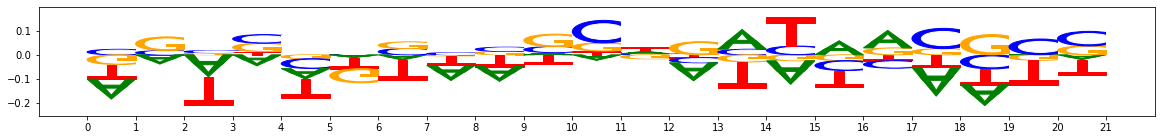

Filter 1


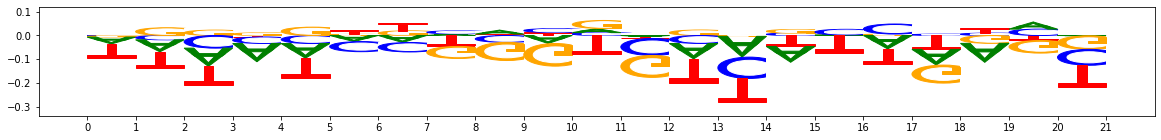

Filter 2


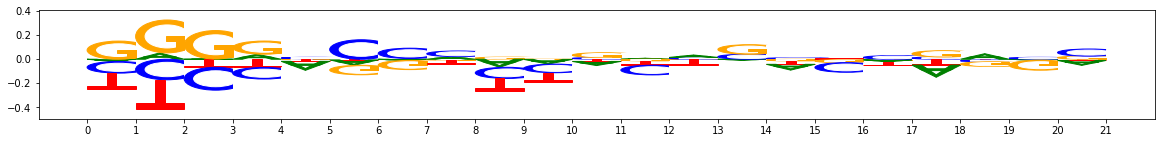

Filter 3


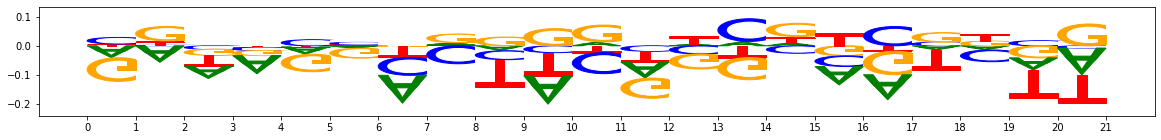

Filter 4


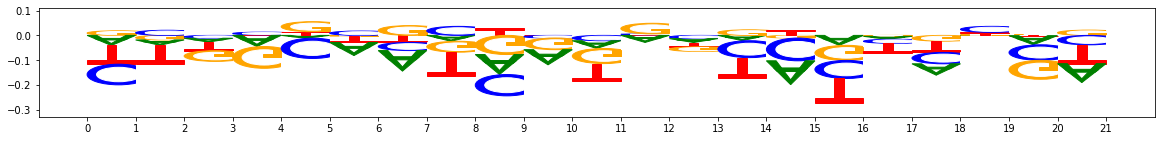

Filter 5


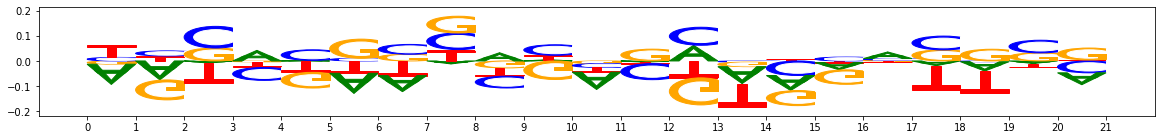

Filter 6


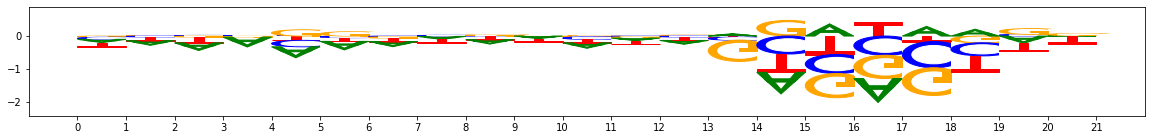

Filter 7


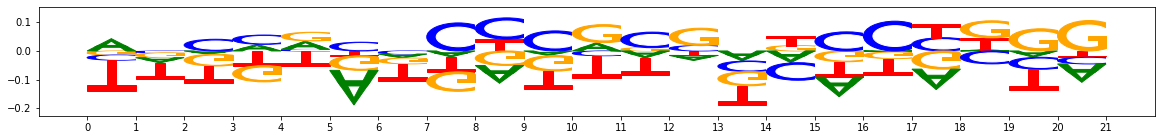

Filter 8


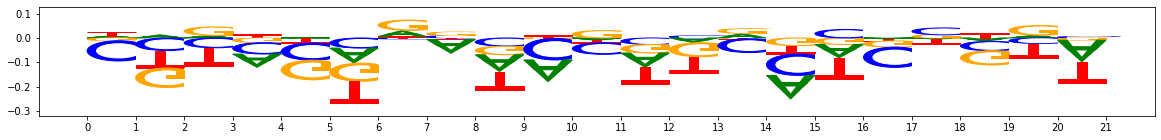

Filter 9


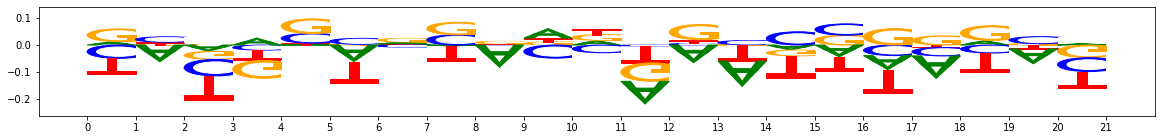

Filter 10


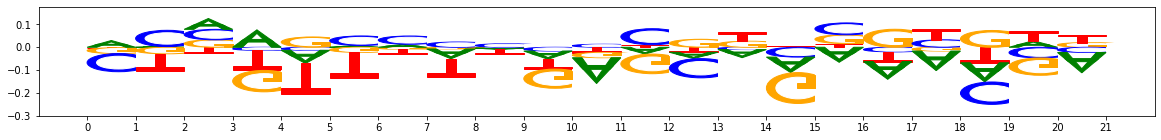

Filter 11


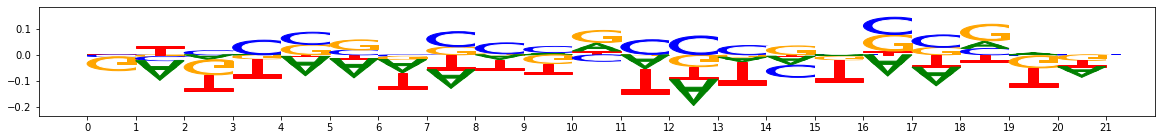

Filter 12


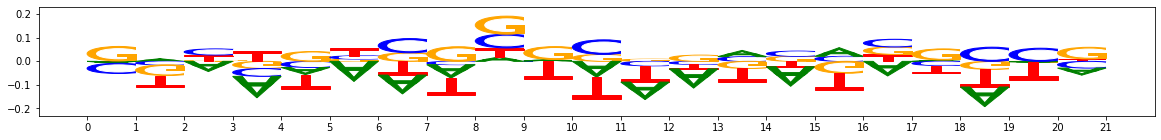

Filter 13


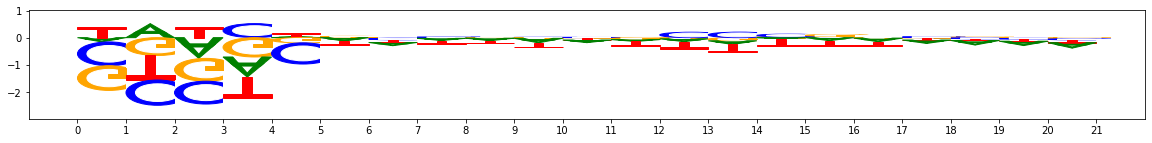

Filter 14


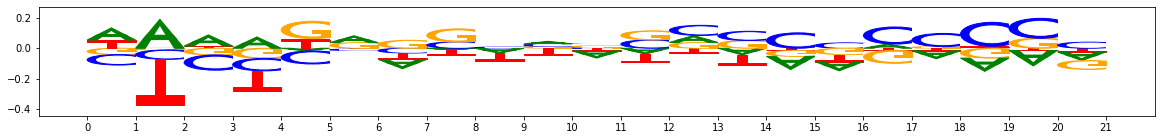

Filter 15


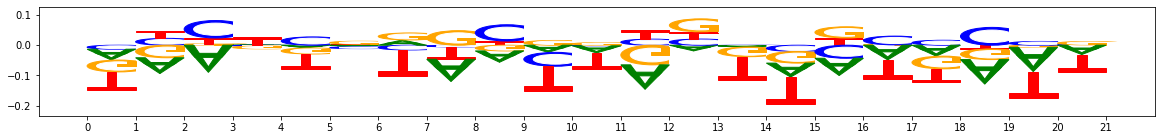

Filter 16


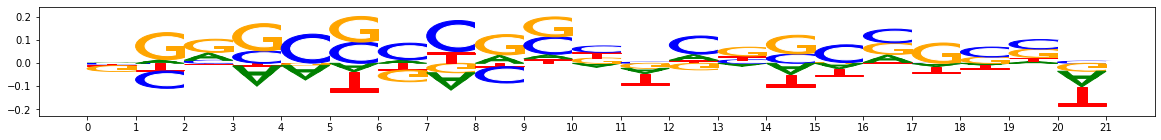

Filter 17


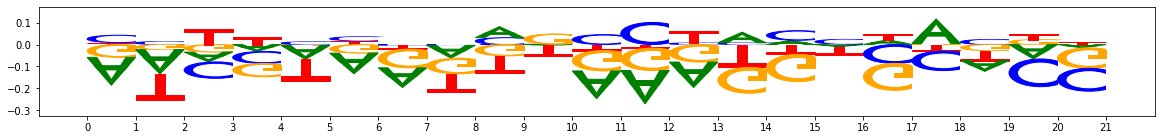

Filter 18


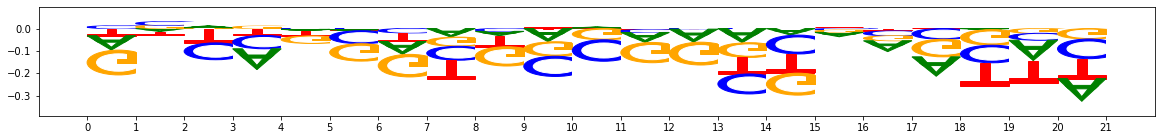

Filter 19


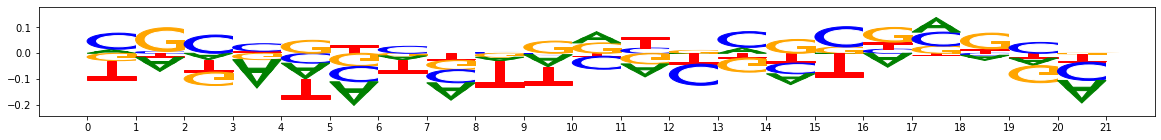

Filter 20


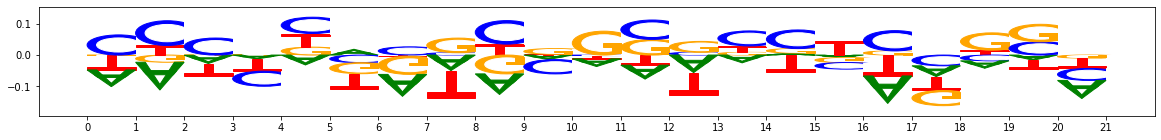

Filter 21


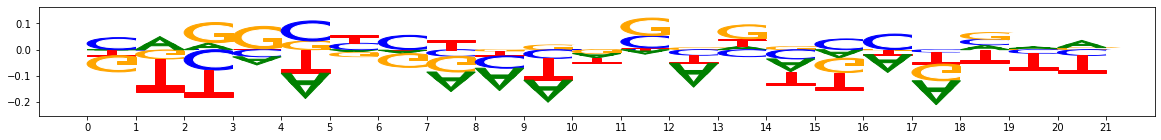

Filter 22


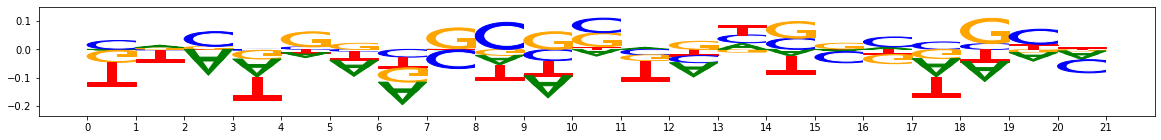

Filter 23


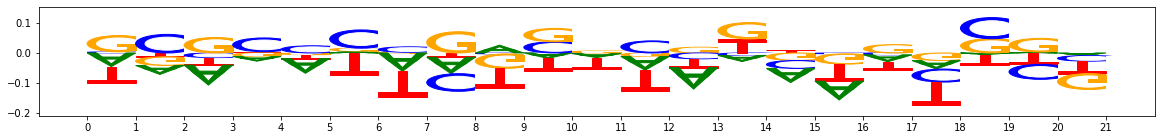

Filter 24


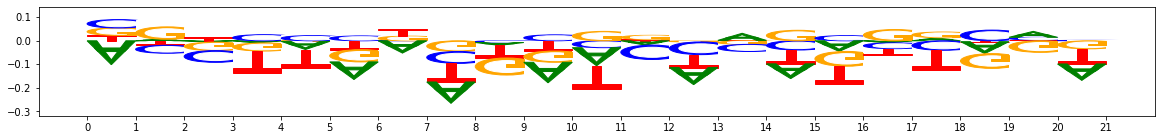

Filter 25


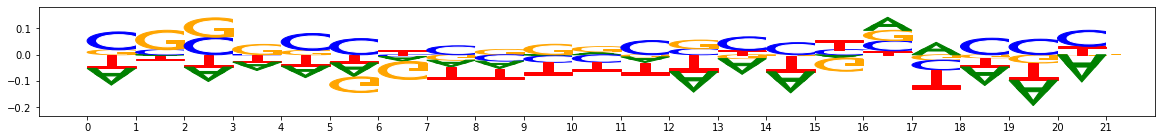

Filter 26


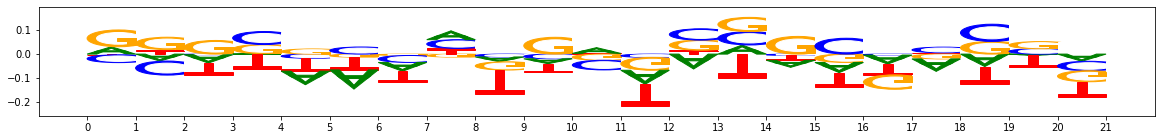

Filter 27


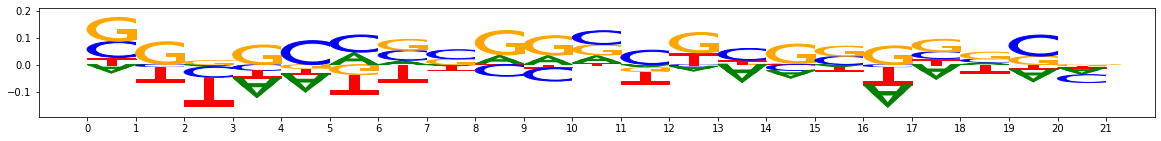

Filter 28


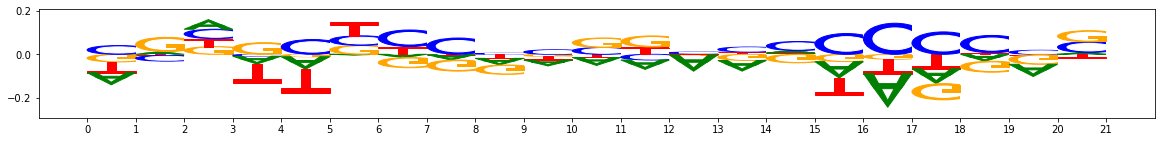

Filter 29


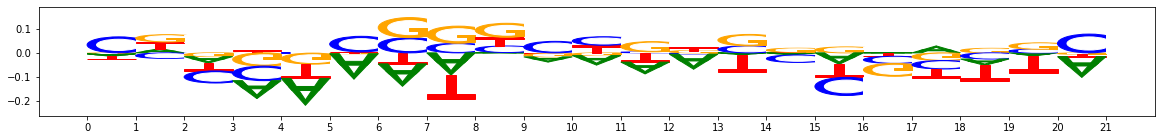

Filter 30


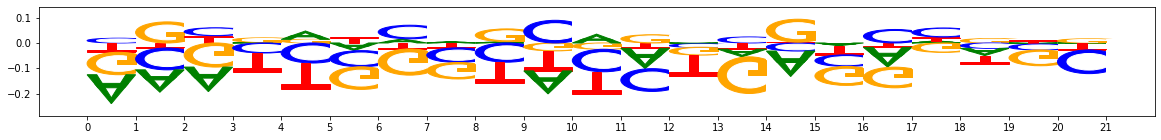

Filter 31


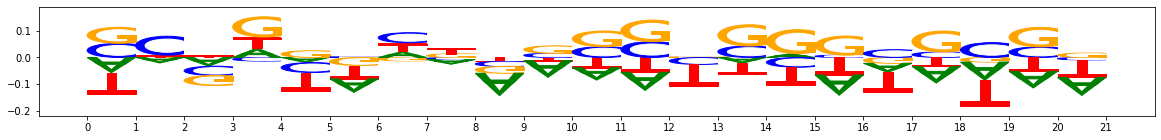

Filter 32


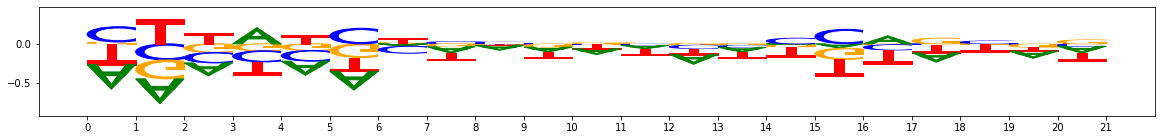

Filter 33


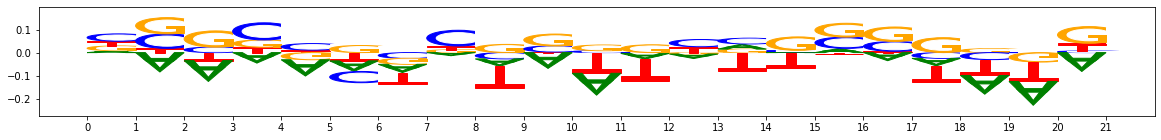

Filter 34


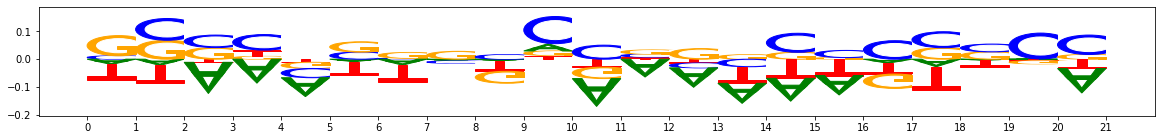

Filter 35


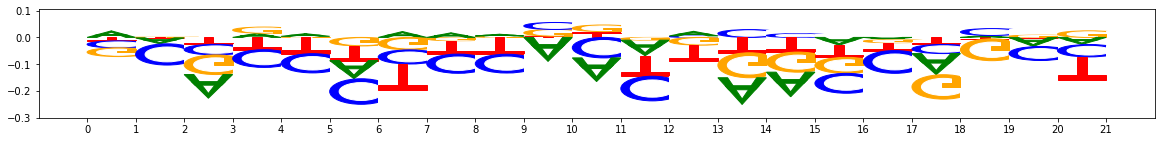

Filter 36


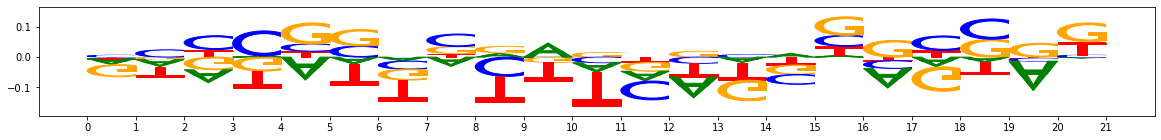

Filter 37


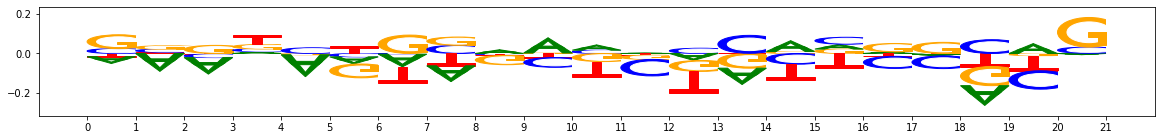

Filter 38


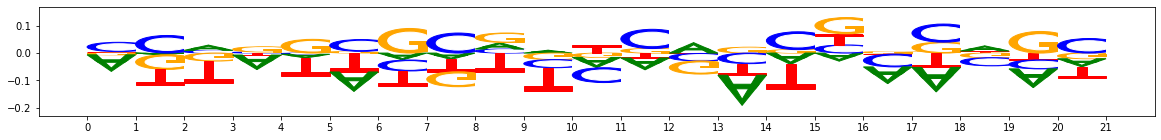

Filter 39


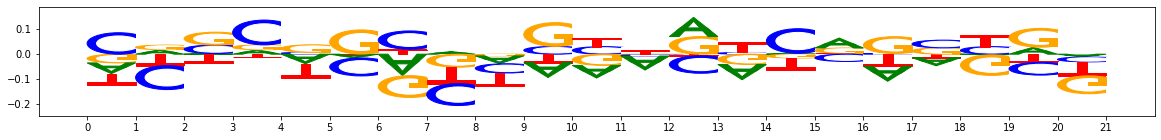

Filter 40


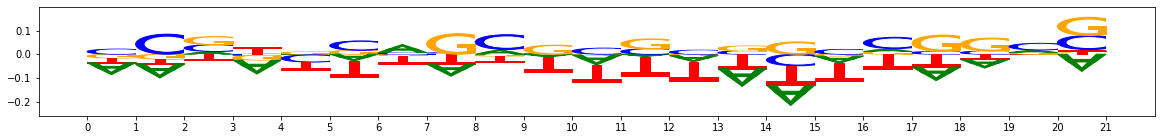

Filter 41


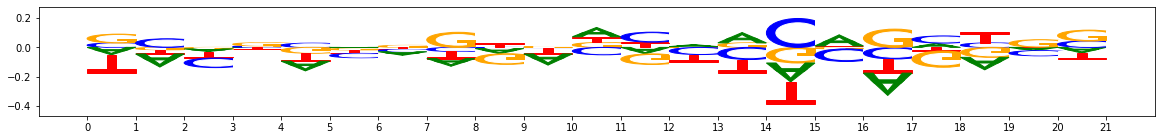

Filter 42


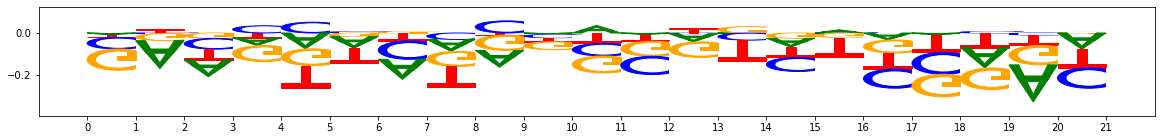

Filter 43


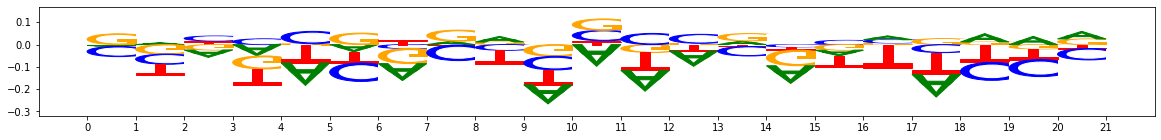

Filter 44


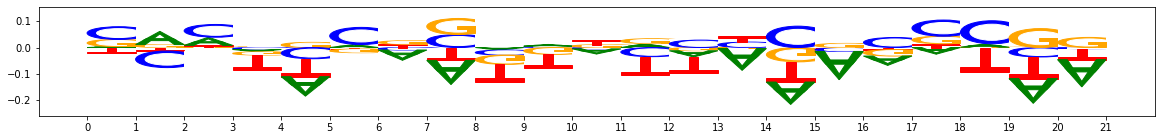

Filter 45


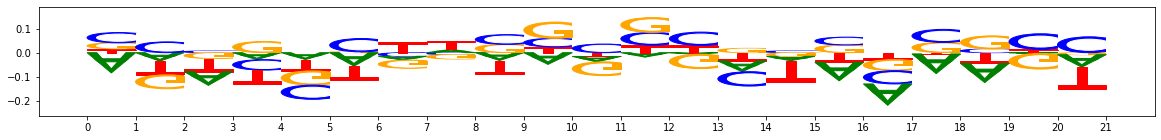

Filter 46


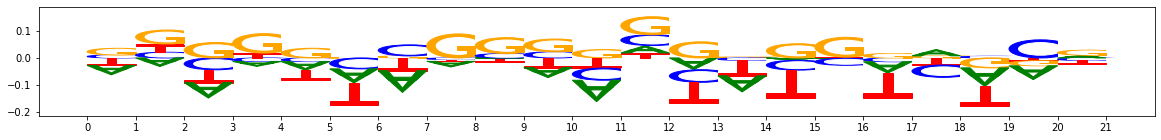

Filter 47


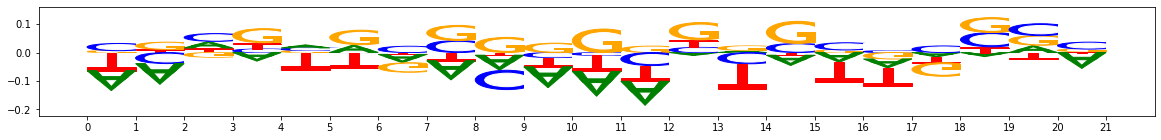

Filter 48


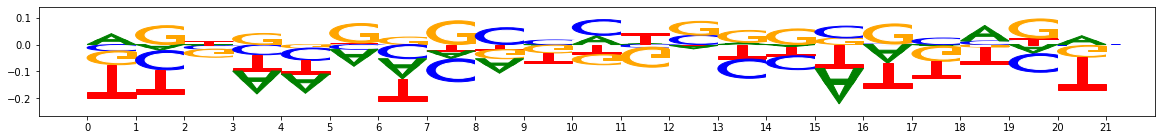

Filter 49


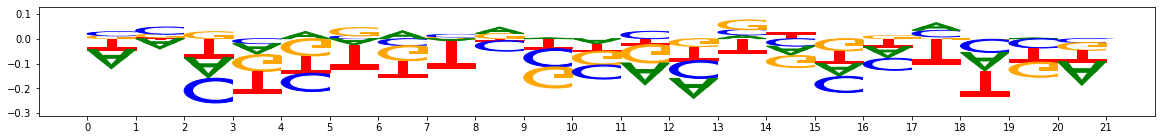

Filter 50


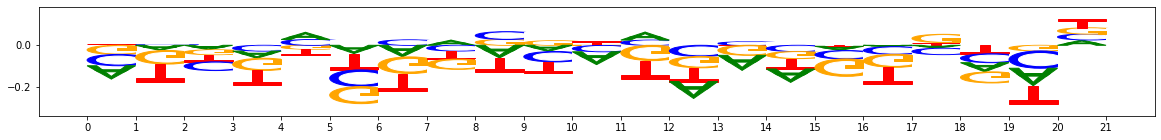

Filter 51


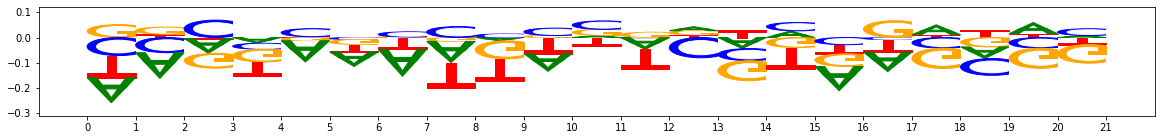

Filter 52


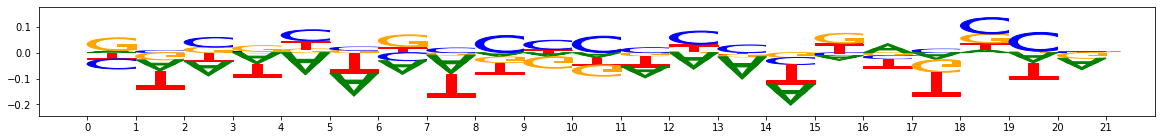

Filter 53


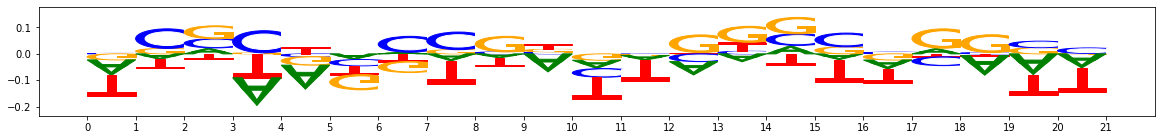

Filter 54


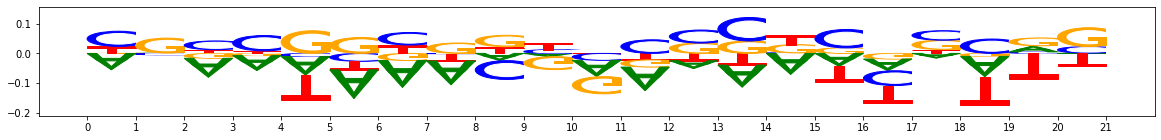

Filter 55


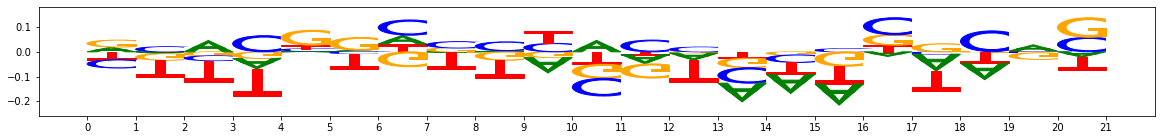

Filter 56


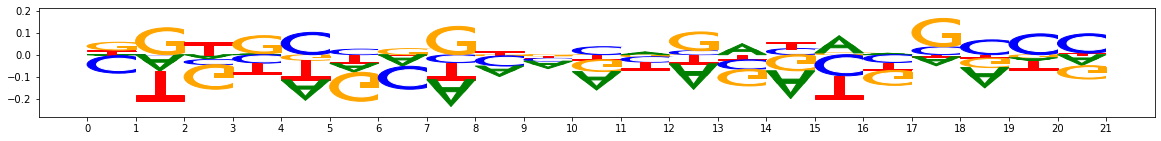

Filter 57


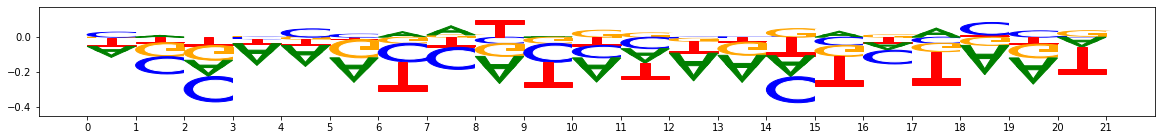

Filter 58


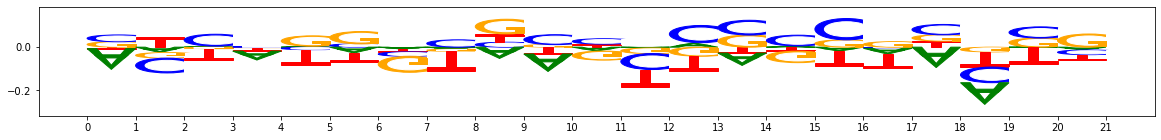

Filter 59


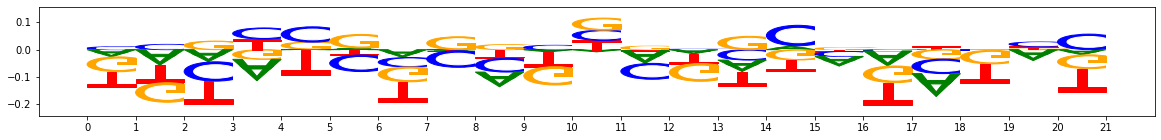

Filter 60


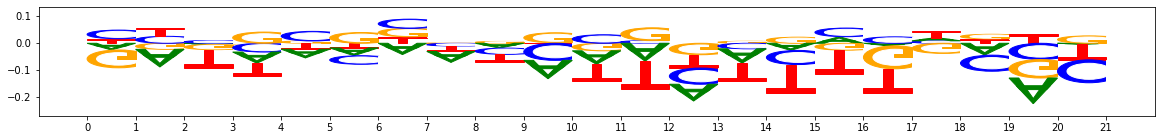

Filter 61


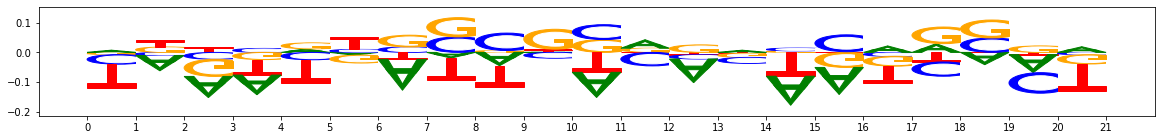

Filter 62


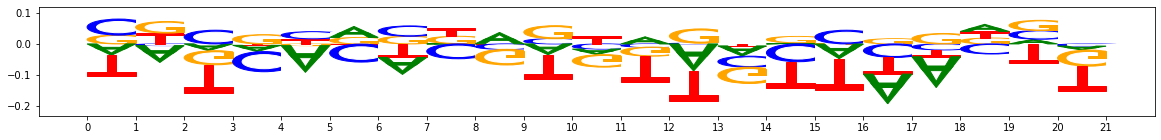

Filter 63


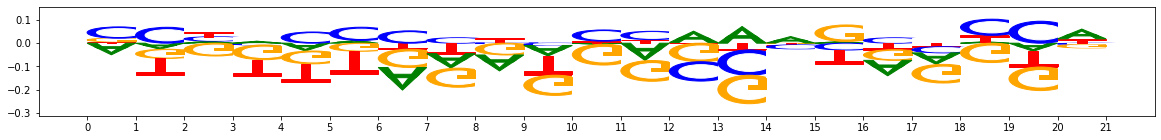

In [15]:
for i in range(num_filters):
    print("Filter %d" % i)
    viz_sequence.plot_weights(filters[0][:, :, i])

### View activating sequences
Like [Bassett](https://genome.cshlp.org/content/26/7/990.full) and [AI-TAC](https://www.biorxiv.org/content/10.1101/2019.12.21.885814v1.full)

In [16]:
filter_pwms = np.empty((num_filters, filter_size, 4))
activation_maxes = np.max(all_activations, axis=(0, 1))
for j in tqdm.notebook.trange(num_filters):
    # For each filter, pick all input windows that yield an activation at least half the maximum
    inds = np.where(all_activations[:, :, j] > 0.5 * activation_maxes[j])
    
    # From these input windows, create a position counts matrix
    pcm = np.zeros((filter_size, 4))
    for i in range(len(inds[0])):
        seq = all_input_seqs[inds[0][i], inds[1][i]:(inds[1][i] + filter_size), :]
        pcm = pcm + seq

    # Convert PCM to PFM to PWM
    pfm = (pcm + 1) / np.sum(pcm + 1, axis=1, keepdims=True)  # LaPlacian smoothing of 1
    pwm = np.log2(pfm / 0.25)
    filter_pwms[j] = pwm

Filter 0


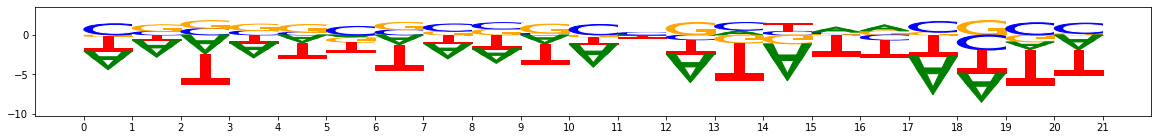

Filter 1


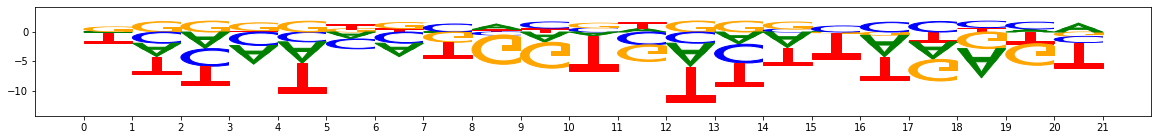

Filter 2


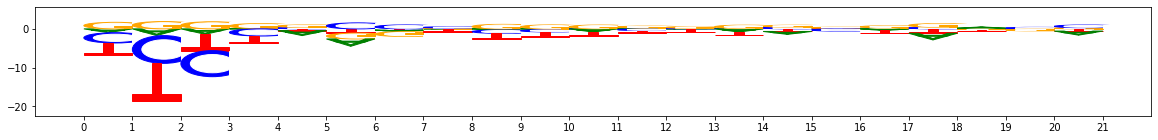

Filter 3


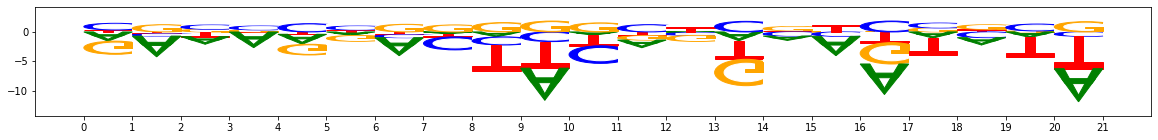

Filter 4


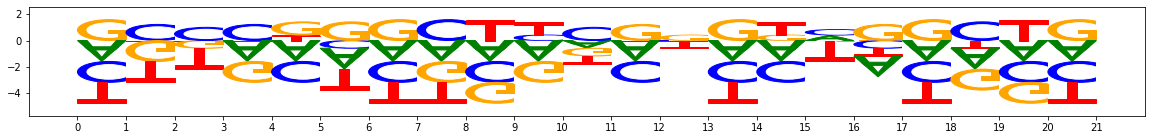

Filter 5


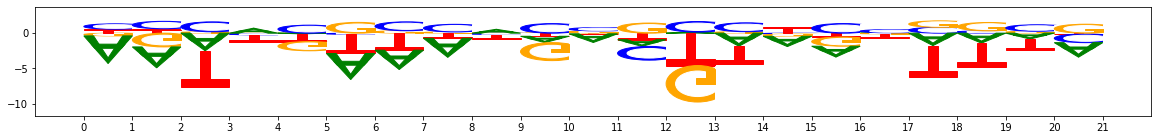

Filter 6


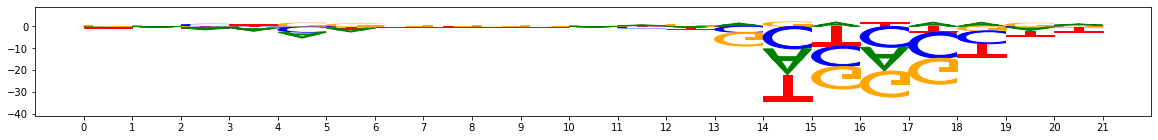

Filter 7


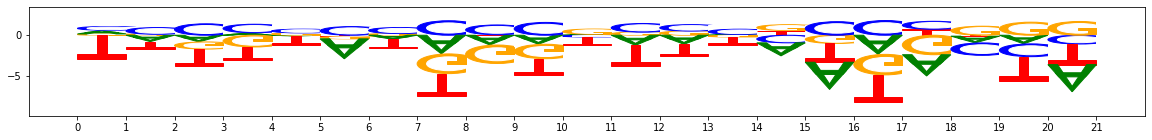

Filter 8


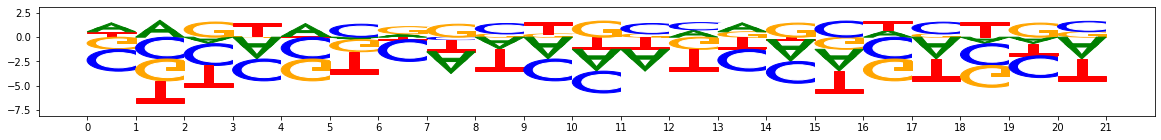

Filter 9


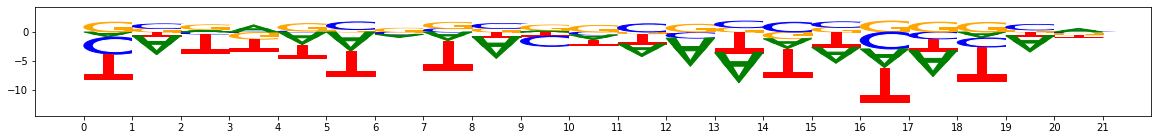

Filter 10


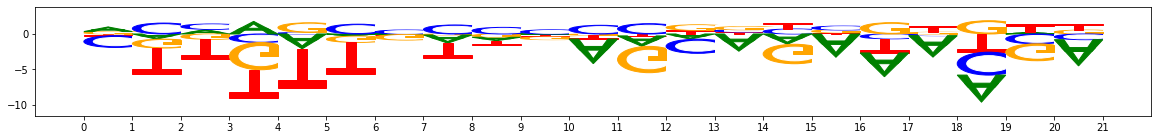

Filter 11


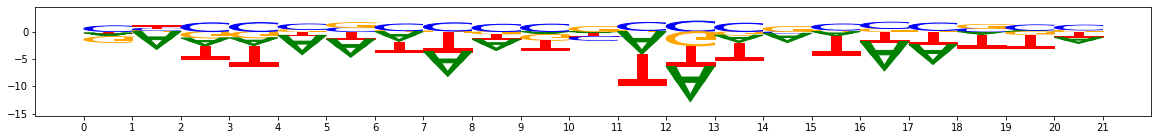

Filter 12


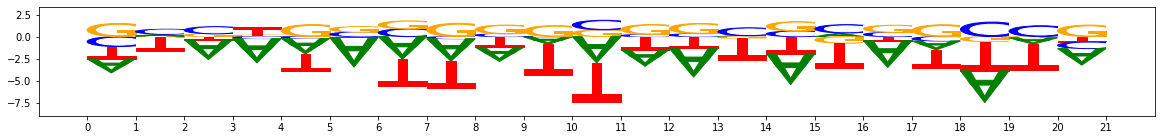

Filter 13


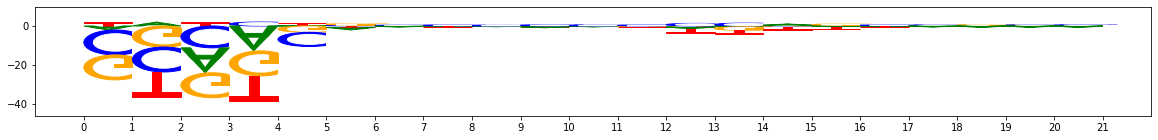

Filter 14


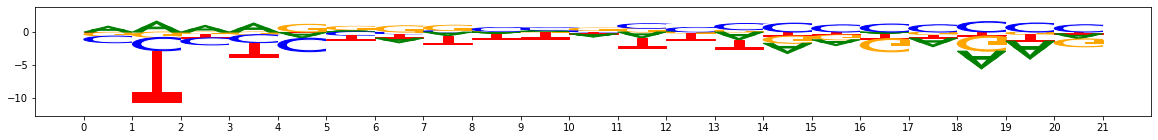

Filter 15


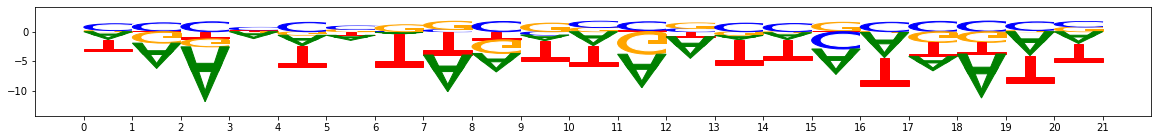

Filter 16


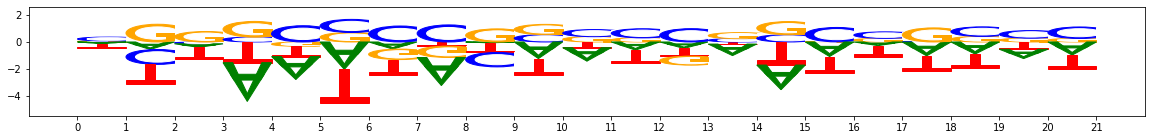

Filter 17


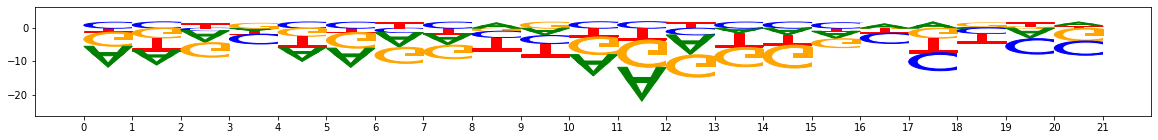

Filter 18


/users/amtseng/lib/tfmodisco/modisco/visualization/viz_sequence.py:125: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)


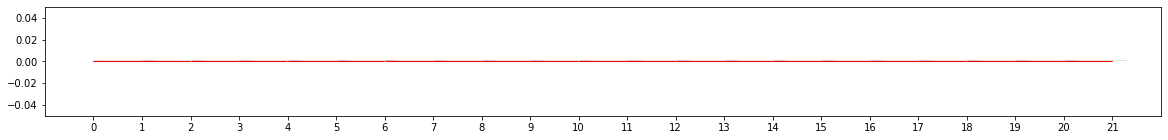

Filter 19


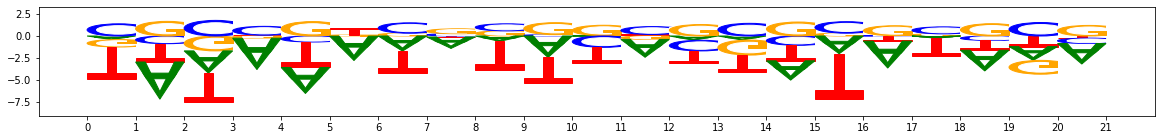

Filter 20


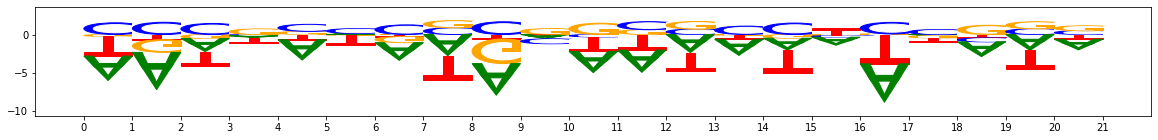

Filter 21


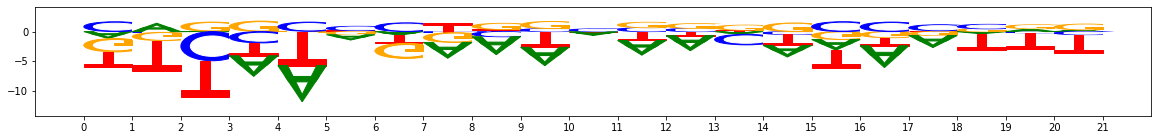

Filter 22


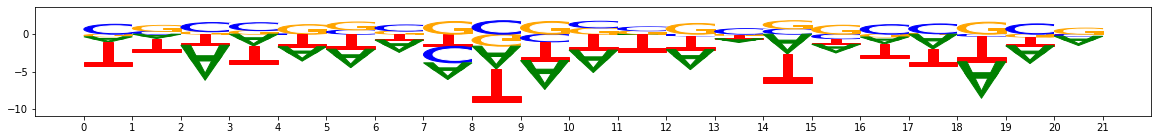

Filter 23


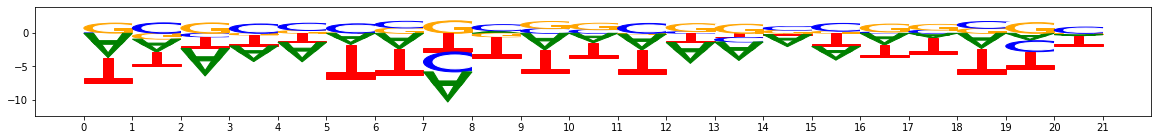

Filter 24


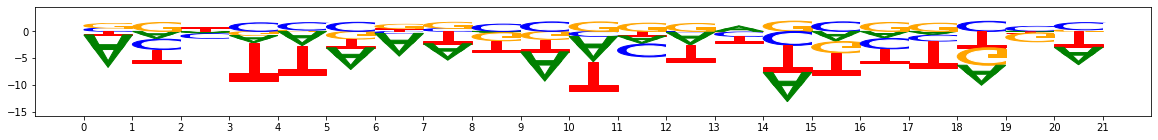

Filter 25


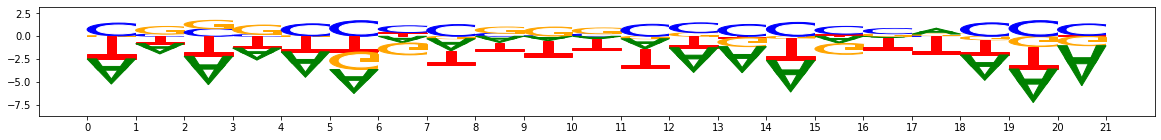

Filter 26


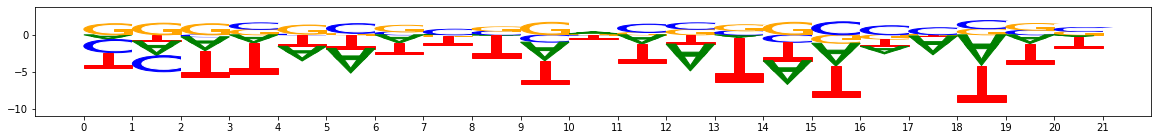

Filter 27


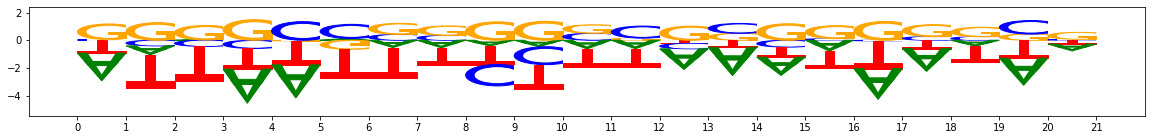

Filter 28


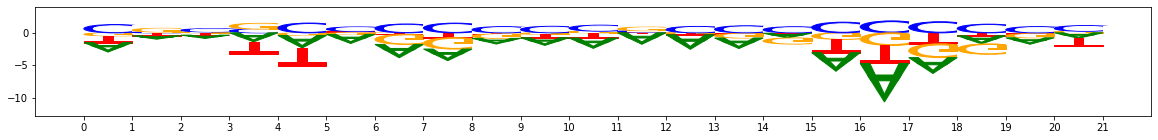

Filter 29


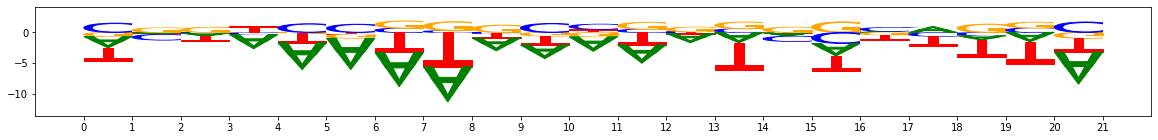

Filter 30


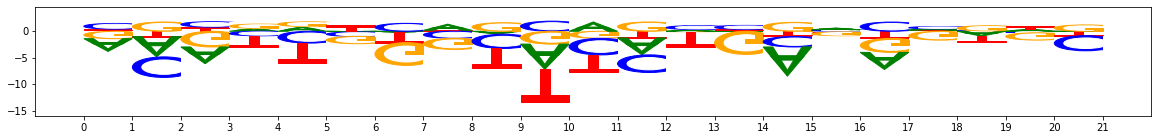

Filter 31


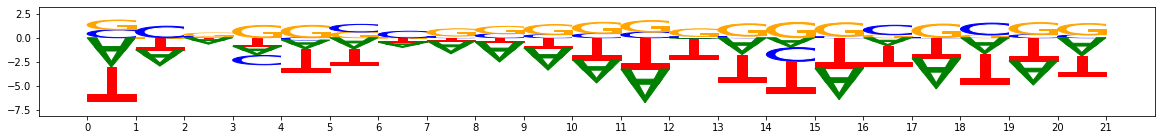

Filter 32


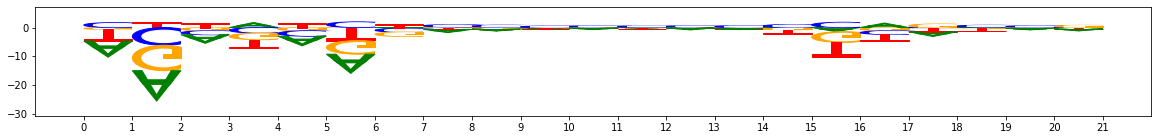

Filter 33


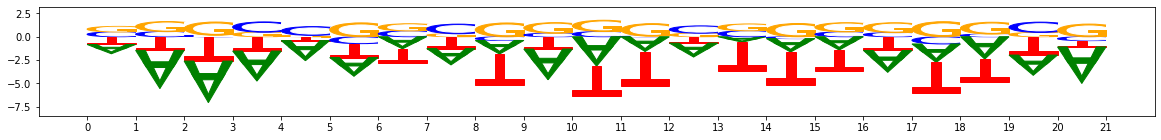

Filter 34


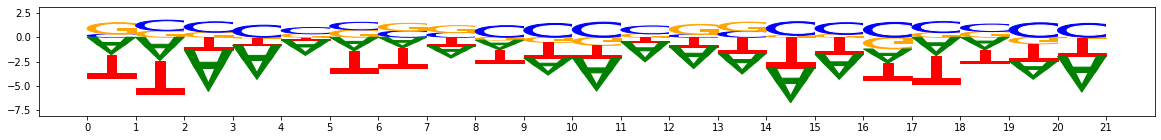

Filter 35


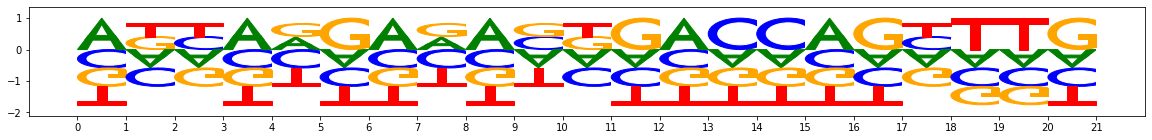

Filter 36


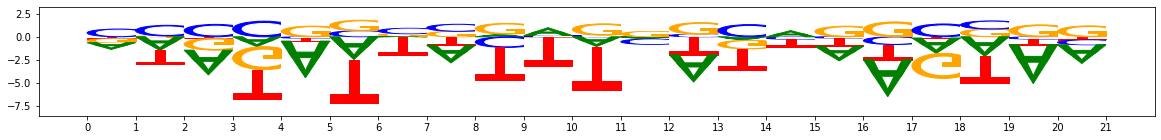

Filter 37


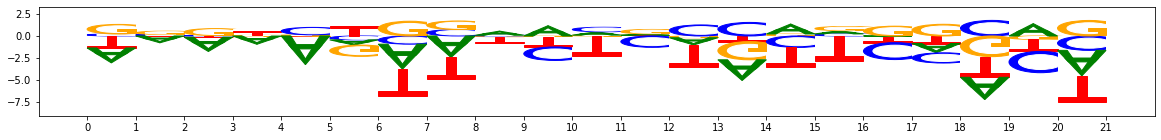

Filter 38


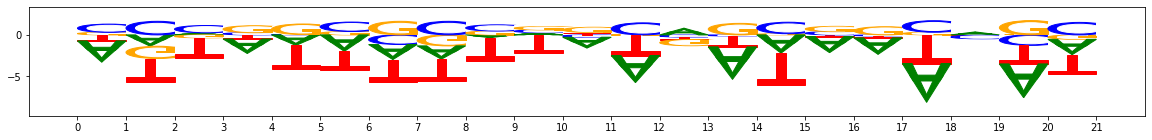

Filter 39


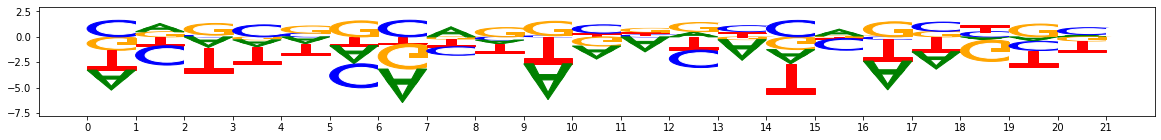

Filter 40


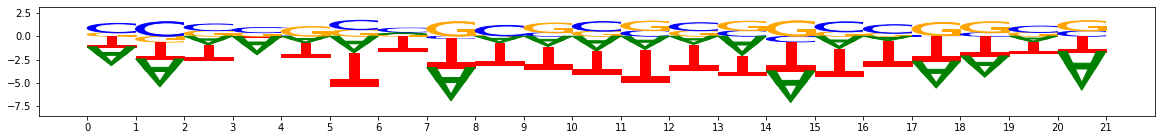

Filter 41


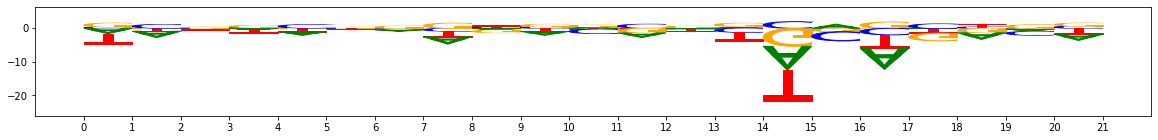

Filter 42


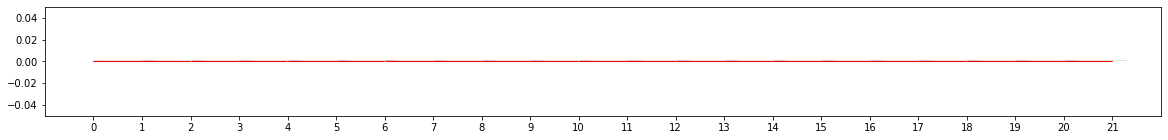

Filter 43


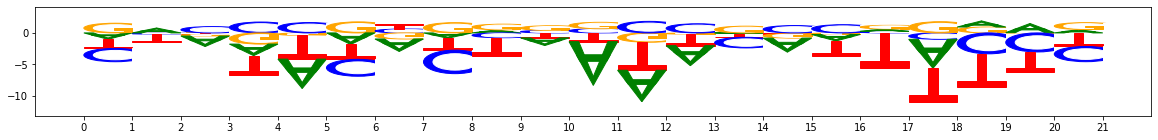

Filter 44


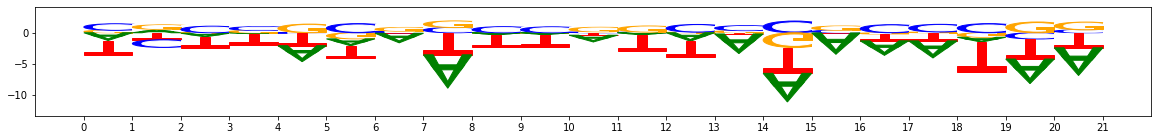

Filter 45


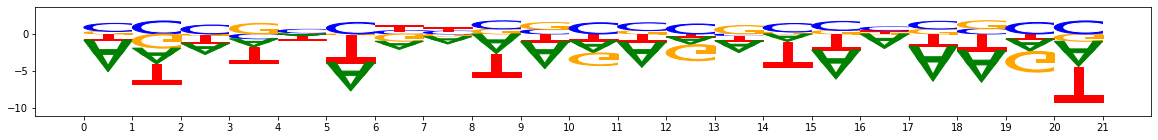

Filter 46


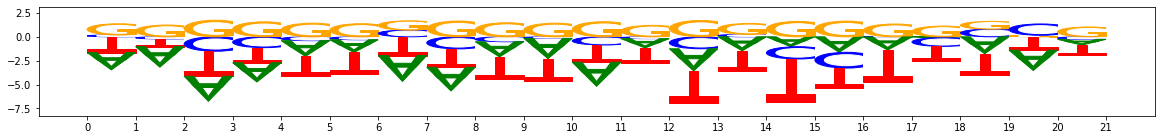

Filter 47


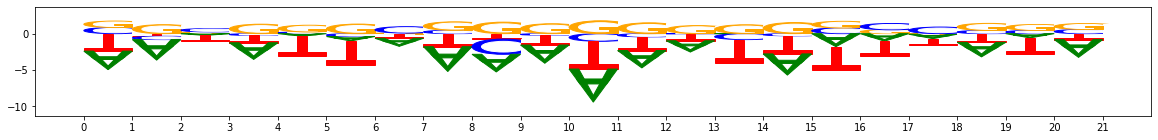

Filter 48


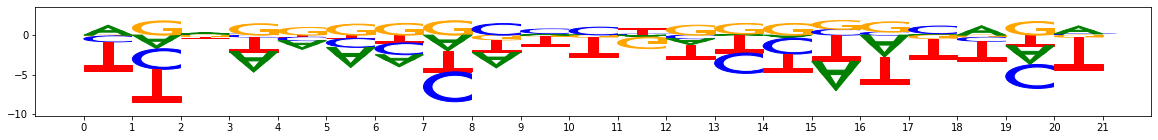

Filter 49


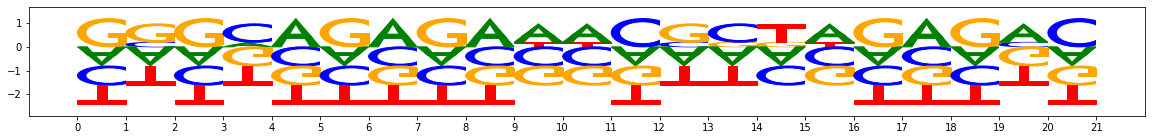

Filter 50


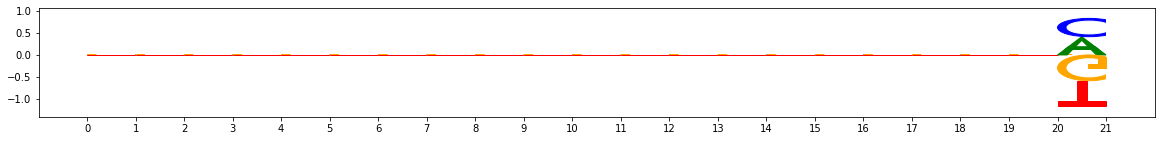

Filter 51


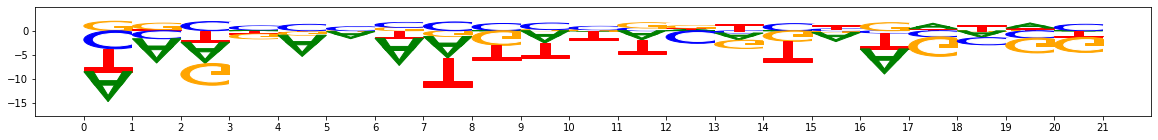

Filter 52


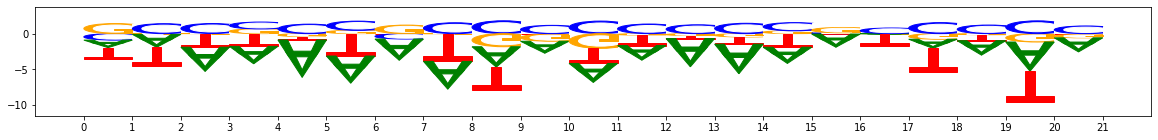

Filter 53


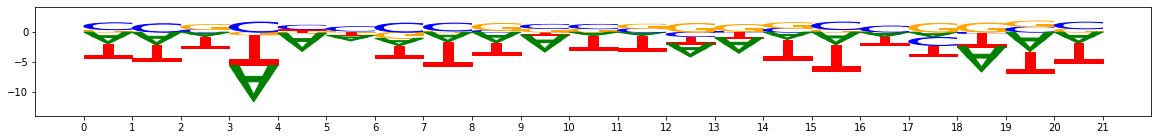

Filter 54


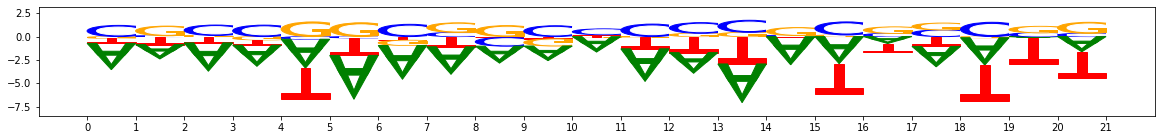

Filter 55


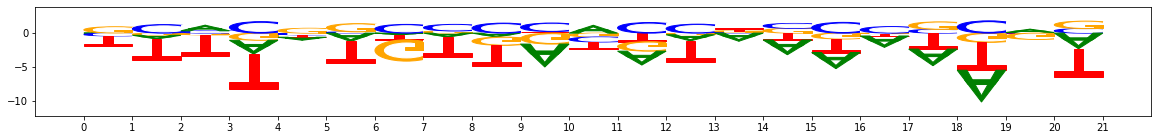

Filter 56


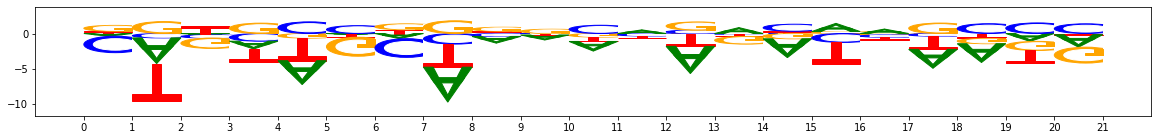

Filter 57


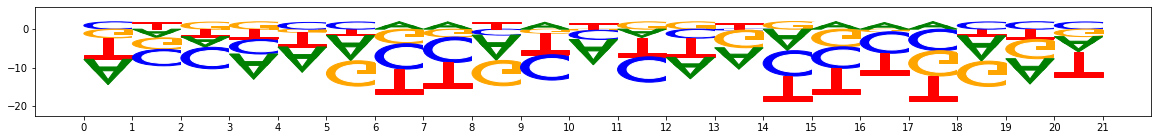

Filter 58


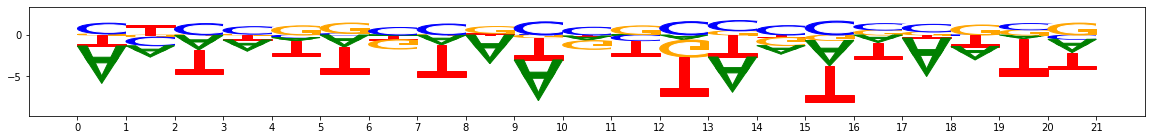

Filter 59


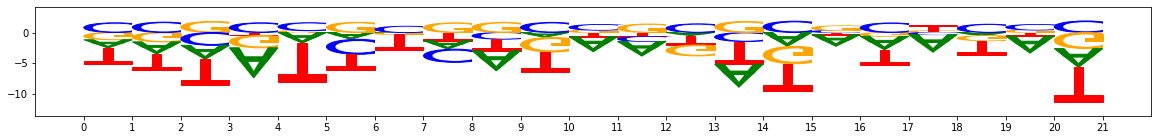

Filter 60


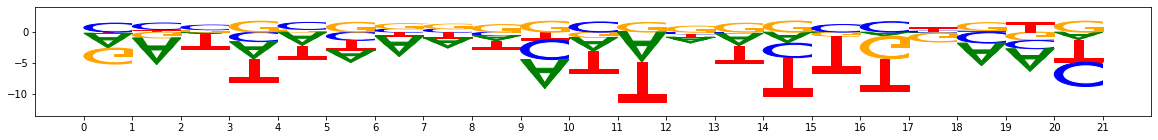

Filter 61


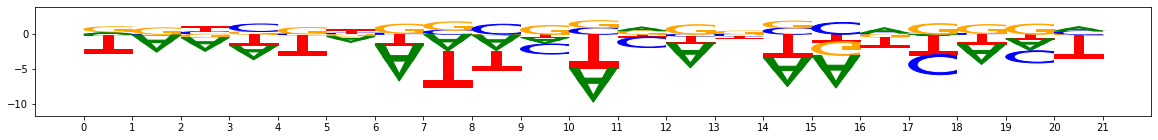

Filter 62


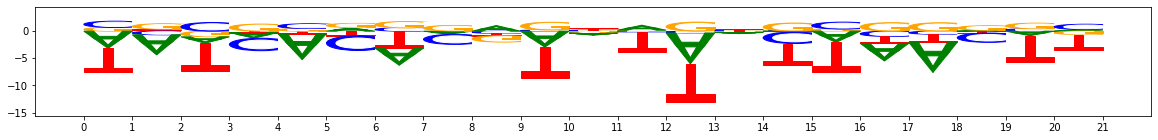

Filter 63


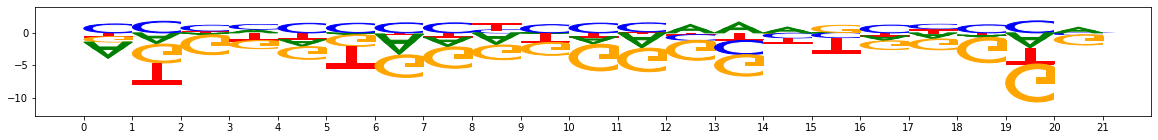

In [17]:
for i in range(num_filters):
    print("Filter %d" % i)
    viz_sequence.plot_weights(filter_pwms[i])